In [43]:
1 / 'Kaggle do not run my notebook' 

TypeError: unsupported operand type(s) for /: 'int' and 'str'

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import folium
from sklearn.metrics.pairwise import haversine_distances

# Read Data 

In [2]:
train_data = pd.read_csv('data/train.csv')
predict_data = pd.read_csv('data/test.csv')

In [3]:
train_data.head()

,dist,due,f_class,lat,lon,s_class,t_class,target
0,5117.239228,2014-01-22 04:10:00.000,econom,55.669290,37.474336,business,NaN,0
1,3638.726690,2014-01-10 13:45:00.000,econom,55.807461,37.635045,business,NaN,0
2,15143.069693,2014-03-02 02:10:00.000,econom,55.741105,37.615821,NaN,NaN,1
3,-1.000000,2014-02-26 13:20:00.000,econom,55.625526,37.618543,NaN,NaN,1
4,4708.142572,2014-01-21 19:45:00.000,business,55.813167,37.597863,NaN,NaN,0


In [4]:
predict_data.head()

,dist,due,f_class,lat,lon,s_class,t_class
0,4611.506701,2014-03-30 11:30:00.000,econom,55.776618,37.682503,NaN,NaN
1,14450.067441,2014-03-06 19:10:00.000,econom,55.754659,37.810072,NaN,NaN
2,17755.993723,2014-03-22 13:30:00.000,business,55.726141,37.587407,NaN,NaN
3,8533.172059,2014-03-22 05:10:00.000,econom,55.794178,37.576456,business,NaN
4,-1.000000,2014-03-12 19:15:00.000,econom,55.757409,37.542186,business,NaN


In [5]:
actual_cities = [
    'Moscow', 
    'Saint Petersburg', 
    'Voronezh', 
    'Kazan', 
    'Nizhniy Novgorod'
]

cities_df = pd.read_csv('data/worldcities.csv').rename(columns={'lng': 'lon'})
cities_df = cities_df[cities_df['city'].isin(actual_cities)]
cities_df.head()

,city,city_ascii,lat,lon,country,iso2,iso3,admin_name,capital,population,id
17,Moscow,Moscow,55.7558,37.6178,Russia,RU,RUS,Moskva,primary,17332000.0,1643318494
123,Saint Petersburg,Saint Petersburg,59.9500,30.3167,Russia,RU,RUS,Sankt-Peterburg,admin,5384342.0,1643616350
606,Nizhniy Novgorod,Nizhniy Novgorod,56.3269,44.0075,Russia,RU,RUS,Nizhegorodskaya Oblast’,admin,1264075.0,1643012126
615,Kazan,Kazan,55.7964,49.1089,Russia,RU,RUS,Tatarstan,admin,1243500.0,1643101260
728,Voronezh,Voronezh,51.6717,39.2106,Russia,RU,RUS,Voronezhskaya Oblast’,admin,1050602.0,1643811064


# Train Test Split

In [6]:
train_data.sort_values(by='due', inplace=True)
train_data.head()

,dist,due,f_class,lat,lon,s_class,t_class,target
823150,17990.125431,2014-01-01 00:09:32.000,econom,55.750130,37.823242,NaN,NaN,1
685195,2322.180999,2014-01-01 00:10:00.000,econom,55.711488,37.884183,NaN,NaN,0
996389,14608.577392,2014-01-01 00:10:00.000,econom,55.633404,37.797595,NaN,NaN,0
497811,20055.569096,2014-01-01 00:10:00.000,econom,55.780380,37.645240,NaN,NaN,0
812346,20585.444093,2014-01-01 00:10:00.000,econom,55.675676,37.500387,NaN,NaN,1


In [7]:
train_size = int(len(train_data) * 0.7)
train_df = train_data.iloc[:train_size, :]
test_df = train_data.iloc[train_size:, :]

# Transformer

In [8]:
class MyTransformer:
    def __init__(self, cities_df):
        self.cities_df = cities_df.copy()

    def fit(self, df):
        self.city_dist_std = None
        self.transform(df)
    
    def fit_transform(self, df):
        self.city_dist_std = None
        df = self.transform(df)
        return df

    def transform(self, df):
        df = df.copy()
        # index
        df['index'] = df.index

        # dist
        df.loc[df['dist'] < 0, 'dist'] = np.nan
        df['dist_nan'] = df['dist'].isna()

        # due
        df['due'] = pd.to_datetime(df['due'])
        df['hour'] = df['due'].dt.hour
        df['weekday'] = df['due'].dt.weekday

        # *_class
        df['multi_class'] = \
            df['f_class'].astype(str) + '_' + \
            df['s_class'].astype(str) + '_' + \
            df['t_class'].astype(str)

        # lat lon
        df['location_nan'] = df['lat'].isna() | df['lon'].isna()

        # cities
        X_train_pos = np.deg2rad(df[['lat', 'lon']].fillna(-1))
        cities_pos = np.deg2rad(self.cities_df[['lat', 'lon']])

        X_train_dists = haversine_distances(X_train_pos, cities_pos) * 6371000/1000
        df['city'] = cities_df['city'].iloc[np.argmin(X_train_dists, axis=1).ravel()].values
        df['city_dist'] = np.min(X_train_dists, axis=1)

        df.loc[df[['lat', 'lon']].isna().any(axis=1), ['city', 'city_dist']] = np.nan

        if self.city_dist_std is None:
            self.city_dist_std = df\
                .groupby('city')['city_dist']\
                .std()\
                .reset_index()\
                .set_axis(['city', 'city_dist_std'], axis=1)

        df = df.merge(self.city_dist_std, on='city', how='left')
        df['city_dist_normed'] = df['city_dist'] / df['city_dist_std']

        # diff time same loc
        df.sort_values(by='due', inplace=True)
        df['diff_time_loc'] = df.groupby(['lat', 'lon'])['due'].diff().dt.seconds
        df['no_prev_loc'] = df['diff_time_loc'].isna()

        return df


In [9]:
transformer = MyTransformer(cities_df)
train_df_trans = transformer.fit_transform(train_df)
test_df_trans = transformer.transform(test_df)

In [10]:
train_df_trans.head()

,dist,due,f_class,lat,lon,s_class,t_class,target,index,dist_nan,hour,weekday,multi_class,location_nan,city,city_dist,city_dist_std,city_dist_normed,diff_time_loc,no_prev_loc
0,17990.125431,2014-01-01 00:09:32,econom,55.750130,37.823242,NaN,NaN,1,823150,False,0,2,econom_nan_nan,False,Moscow,12.871245,6.879482,1.870962,NaN,True
1,2322.180999,2014-01-01 00:10:00,econom,55.711488,37.884183,NaN,NaN,0,685195,False,0,2,econom_nan_nan,False,Moscow,17.390144,6.879482,2.527828,NaN,True
2,14608.577392,2014-01-01 00:10:00,econom,55.633404,37.797595,NaN,NaN,0,996389,False,0,2,econom_nan_nan,False,Moscow,17.668855,6.879482,2.568341,NaN,True
3,20055.569096,2014-01-01 00:10:00,econom,55.780380,37.645240,NaN,NaN,0,497811,False,0,2,econom_nan_nan,False,Moscow,3.227437,6.879482,0.469140,NaN,True
4,20585.444093,2014-01-01 00:10:00,econom,55.675676,37.500387,NaN,NaN,1,812346,False,0,2,econom_nan_nan,False,Moscow,11.552596,6.879482,1.679283,NaN,True


In [11]:
test_df_trans.head()

,dist,due,f_class,lat,lon,s_class,t_class,target,index,dist_nan,hour,weekday,multi_class,location_nan,city,city_dist,city_dist_std,city_dist_normed,diff_time_loc,no_prev_loc
0,6218.571076,2014-02-15 14:05:00,econom,55.714744,37.553828,NaN,NaN,0,962287,False,14,5,econom_nan_nan,False,Moscow,6.072958,6.879482,0.882764,NaN,True
30,8387.190228,2014-02-15 14:05:00,econom,55.740841,37.499363,business,NaN,0,5616,False,14,5,econom_business_nan,False,Moscow,7.596574,6.879482,1.104236,NaN,True
29,NaN,2014-02-15 14:05:00,business,55.679531,37.525604,vip,NaN,0,1091093,True,14,5,business_vip_nan,False,Moscow,10.259977,6.879482,1.491388,NaN,True
28,56624.359721,2014-02-15 14:05:00,econom,55.414327,37.900470,NaN,NaN,0,1040241,False,14,5,econom_nan_nan,False,Moscow,41.920116,6.879482,6.093499,NaN,True
27,19986.691127,2014-02-15 14:05:00,econom,55.734719,37.423303,NaN,NaN,0,177901,False,14,5,econom_nan_nan,False,Moscow,12.396938,6.879482,1.802016,NaN,True


In [12]:
num_features = [
    'dist', 'lat', 'lon', 
    'city_dist', 'city_dist_normed', 'diff_time_loc'
]

cat_features = [
    'f_class', 's_class', 't_class', 
    'dist_nan', 'hour', 'weekday', 
    'multi_class', 'location_nan', 'city', 
    'no_prev_loc'
]

# Catboost model

In [13]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score
from catboost import CatBoostClassifier
beta = 0.2

In [14]:
X_train = train_df_trans[num_features + cat_features].copy()
X_train[cat_features] = X_train[cat_features].astype(str)
y_train = train_df_trans['target']

X_test = test_df_trans[num_features + cat_features].copy()
X_test[cat_features] = X_test[cat_features].astype(str)
y_test = test_df_trans['target']

In [38]:
model = CatBoostClassifier(cat_features=cat_features)
model.fit(X_train, y_train, verbose=False)

In [39]:
y_pred = model.predict(X_test)
fbeta_score(y_test, y_pred, beta=beta)

0.38065001253237535

In [42]:
y_pred = model.predict_proba(X_test)[:, 1]

for t in np.arange(0.1, 1, 0.01):
    print(t, fbeta_score(y_test, y_pred > t, beta=beta))

0.1 0.17810860409026008
0.15000000000000002 0.23474550215033313
0.20000000000000004 0.3025901186937509
0.25000000000000006 0.36440942046548347
0.30000000000000004 0.40698135010285175
0.3500000000000001 0.42482677054006457
0.40000000000000013 0.4252990705584686
0.45000000000000007 0.4096324437536101
0.5000000000000001 0.38065001253237535
0.5500000000000002 0.3298500911607806
0.6000000000000002 0.2734716333861937
0.6500000000000001 0.19972043319790453
0.7000000000000002 0.12261530478312628
0.7500000000000002 0.06846466069571634
0.8000000000000002 0.03411528982038051
0.8500000000000002 0.010947969682545496
0.9000000000000002 0.0028903876083895353
0.9500000000000003 0.0


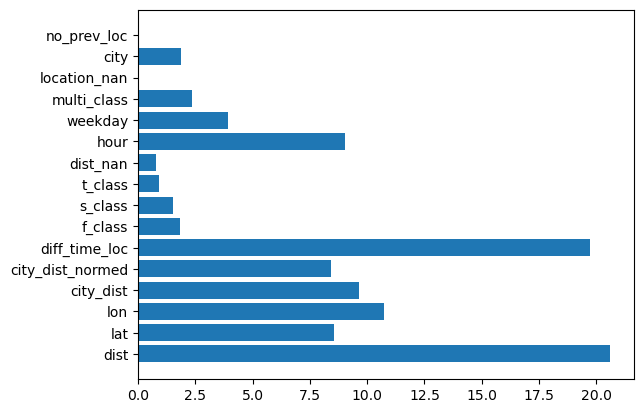

In [40]:
plt.barh(y=X_train.columns, width=model.feature_importances_)
plt.show()

# LightGBM

In [24]:
X_train[cat_features] = X_train[cat_features].apply(lambda x: pd.factorize(x)[0])
X_test[cat_features] = X_test[cat_features].apply(lambda x: pd.factorize(x)[0])

In [33]:
model = LGBMClassifier(n_estimators=1000)
model.fit(X_train, y_train, categorical_feature=cat_features)

c:\Users\justw\miniconda3\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


LGBMClassifier(n_estimators=1000)

In [34]:
y_pred = model.predict(X_test)
fbeta_score(y_test, y_pred, beta=beta)

0.35194192117874257

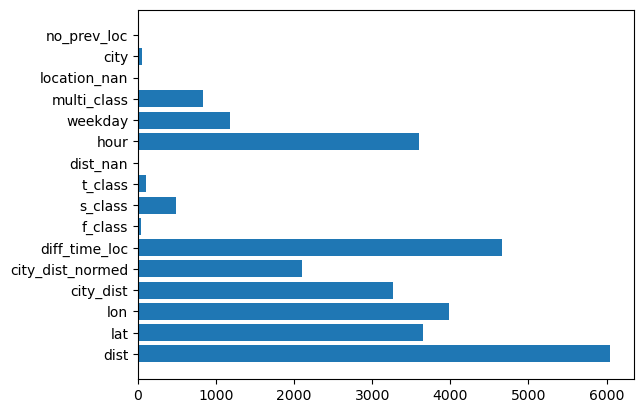

In [35]:
plt.barh(y=X_train.columns, width=model.feature_importances_)
plt.show()